# Video Classification using CNN-RNN Model

## Contents

**1. Importing Libraries**\
**2. About the Data**\
**3. Imporitng Data**\
**4. Processing Data**\
**5. Exploratory Data Analysis**\
        (a) Anaysis\
**6. Helper Functions**\
        (a) Video Loader\
        (b) Feature Extractor\
        (c) Label Encdoer\
**7. Convolutional Nueral Network**\
**8. Recurrent Nueral Network**\
**9. Model Training**\
    (a) RNN GRU\
    (b) RNN LSTM\
**10. Model Test Results**\
    (a) GRU\
    (b) LSTM\
**11. CNN Extractor Tweaking**\
    (a) resnet50\
    (b) inception_v3\
**12. Results & Analysis**\
    (a) RNN Model Architecture Comparison\
    (b) CNN Model Architecture Comparison\
    (c) Optimizer Selection\
    (d) Hyperparameter Tweaking\
    (e) Analysis\
**13. Conclusion**\
**14. References**

## 1. Importing Libraries

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import matplotlib

In [25]:
from imutils import paths
import tensorflow as tf
import imageio
from tensorflow.keras import applications
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.layers import GRU, Dropout, Dense , LSTM
from keras.callbacks import CSVLogger
from IPython.display import Video

## 2. About the Data

With the ever increasing reach and usage of social websites, it has become quite easy to share videos on different platforms like 'Youtube','DailyMotion','vimeo','facebook, 'instagram','twitter' and many more. Along this, it has also become quite important categorize the videos for various purposes such as tagging for recommendations and even assisting in removing possible unauthorized content. For all these purposes, "Video Classification" has become extremely important and in order to go through huge volumes of data, these is an evermore need for automation in this regard. 

The dataset was taken from the website: https://www.crcv.ucf.edu/data/UCF_Sports_Action.php and has been attributed to two papers that are lsited as follows:

1. Mikel D. Rodriguez, Javed Ahmed, and Mubarak Shah, Action MACH: A Spatio-temporal Maximum Average Correlation Height Filter for Action Recognition, Computer Vision and Pattern Recognition, 2008.

2. Khurram Soomro and Amir R. Zamir, Action Recognition in Realistic Sports Videos, Computer Vision in Sports. Springer International Publishing, 2014.

The dataset contained a total of **13 listed sports actions** with some videos denoting the same action but at different stages like 'golf forward swing' and 'gold rear swing'. Such actions were accumated into a single folder due to very close similarity which might have reduced model accuracy towards the end result. A total of **139 videos** were used in **.avi** format having a pixel quality of **720 x 480.** A total of 9 videos were taken from different categories were taken and seperated for the testing purposes. we will attempt to classify any given video by passing it through our model which would be a combination of Convolutional Neural Network and Recurrent Neural Network to correctly classify them depending on the action being performed by the person. 

## 3. Importing Data

In [12]:
train_path = os.listdir(r"Data/Train")
test_path = os.listdir(r"Data/test")

In [13]:
train_path

['Diving-Side',
 'Golf-Swing',
 'Kicking',
 'Lifting',
 'Riding-Horse',
 'Run-Side',
 'SkateBoarding',
 'Swing',
 'Walk-Front']

In [14]:
test_path

['Diving-Side',
 'Golf-Swing',
 'Kicking',
 'Lifting',
 'Riding-Horse',
 'Run-Side',
 'SkateBoarding',
 'Swing',
 'Walk-Front']

In [15]:
len(train_path) , len(test_path)

(9, 9)

## 4. Processing Data

Now, what we need to do is organize our training and test data into a csv with 2 columns such that the name / ID of the video is present against the label with respect to that video. To do this we will iterate over all the videos sequentially and store them in lists before joining the two lists to make a single dataframe.

In [16]:
train_labels = []
train_video_ID = []

for i in range(len(train_path)):
    
    temp_path = os.path.join(r"Data\Train" , train_path[i])
    for j in range(len(os.listdir(temp_path))):
        
        train_labels.append(train_path[i])
        
        name = os.path.join(temp_path , os.listdir(temp_path)[j])
        
        train_video_ID.append(name)

In [17]:
test_labels = []
test_video_ID = []

for i in range(len(test_path)):
    
    temp_path = os.path.join(r"Data\Test" , test_path[i])
    
    for j in range(len(os.listdir(temp_path))):
        
        test_labels.append(test_path[i])
        
        name = os.path.join(temp_path , os.listdir(temp_path)[j])        
        test_video_ID.append(name)

In [18]:
data_train = list(zip(train_video_ID , train_labels))
df_train = pd.DataFrame(data_train, columns = ['video_name', 'Label'])

data_test = list(zip(test_video_ID , test_labels))
df_test = pd.DataFrame(data_test, columns = ['video_name', 'Label'])

In [19]:
df_train

,video_name,Label
0,Data\Train\Diving-Side\2538-11_70015.avi,Diving-Side
1,Data\Train\Diving-Side\2538-12_70246.avi,Diving-Side
2,Data\Train\Diving-Side\2538-16_70032.avi,Diving-Side
3,Data\Train\Diving-Side\4475-1_70541.avi,Diving-Side
4,Data\Train\Diving-Side\4475-2_70045.avi,Diving-Side
...,...,...
125,Data\Train\Walk-Front\RF1-18566_700411.avi,Walk-Front
126,Data\Train\Walk-Front\RF1-18566_700560.avi,Walk-Front
127,Data\Train\Walk-Front\RF1-18598_70075.avi,Walk-Front
128,Data\Train\Walk-Front\RF1-18598_70530.avi,Walk-Front


In [20]:
df_test

,video_name,Label
0,Data\Test\Diving-Side\2538-5_70133.avi,Diving-Side
1,Data\Test\Golf-Swing\3283-8_700741.avi,Golf-Swing
2,Data\Test\Golf-Swing\7603-4_70159.avi,Golf-Swing
3,Data\Test\Golf-Swing\RF1-13207_7015.avi,Golf-Swing
4,Data\Test\Kicking\3833-15_70577.avi,Kicking
5,Data\Test\Kicking\778-62_l146.avi,Kicking
6,Data\Test\Lifting\3528-8_70514.avi,Lifting
7,Data\Test\Riding-Horse\4456-16_700040.avi,Riding-Horse
8,Data\Test\Run-Side\2670-5_70111.avi,Run-Side
9,Data\Test\SkateBoarding\708-75070.avi,SkateBoarding


The following is a sample video of a gymnast swinging. The video was converted to mp4 from avi since the .avi format was not working on the notebook. One thing to note here is that 'getty images' paint on the front is present in many videos which migh result in unnecessary noise compromising the model accuracy at a later stage.

In [26]:
Video("test.mp4")

We won't need to resort to any further processing on the data since it is in the form of videos. We will design helper functions to extract the requisite information after we take an overlook on data itself in EDA.

## 5. Exploratory Data Analysis

In [24]:
font = {'size'   : 19}

matplotlib.rc('font', **font)

In [27]:
## Train Data
action = []
no_of_clip = []

for i in range(len(train_path)):
    action.append(train_path[i])
    
    no_of_clip.append(len(os.listdir(os.path.join(r"Data\Train" , 
                                               train_path[i]))))
    

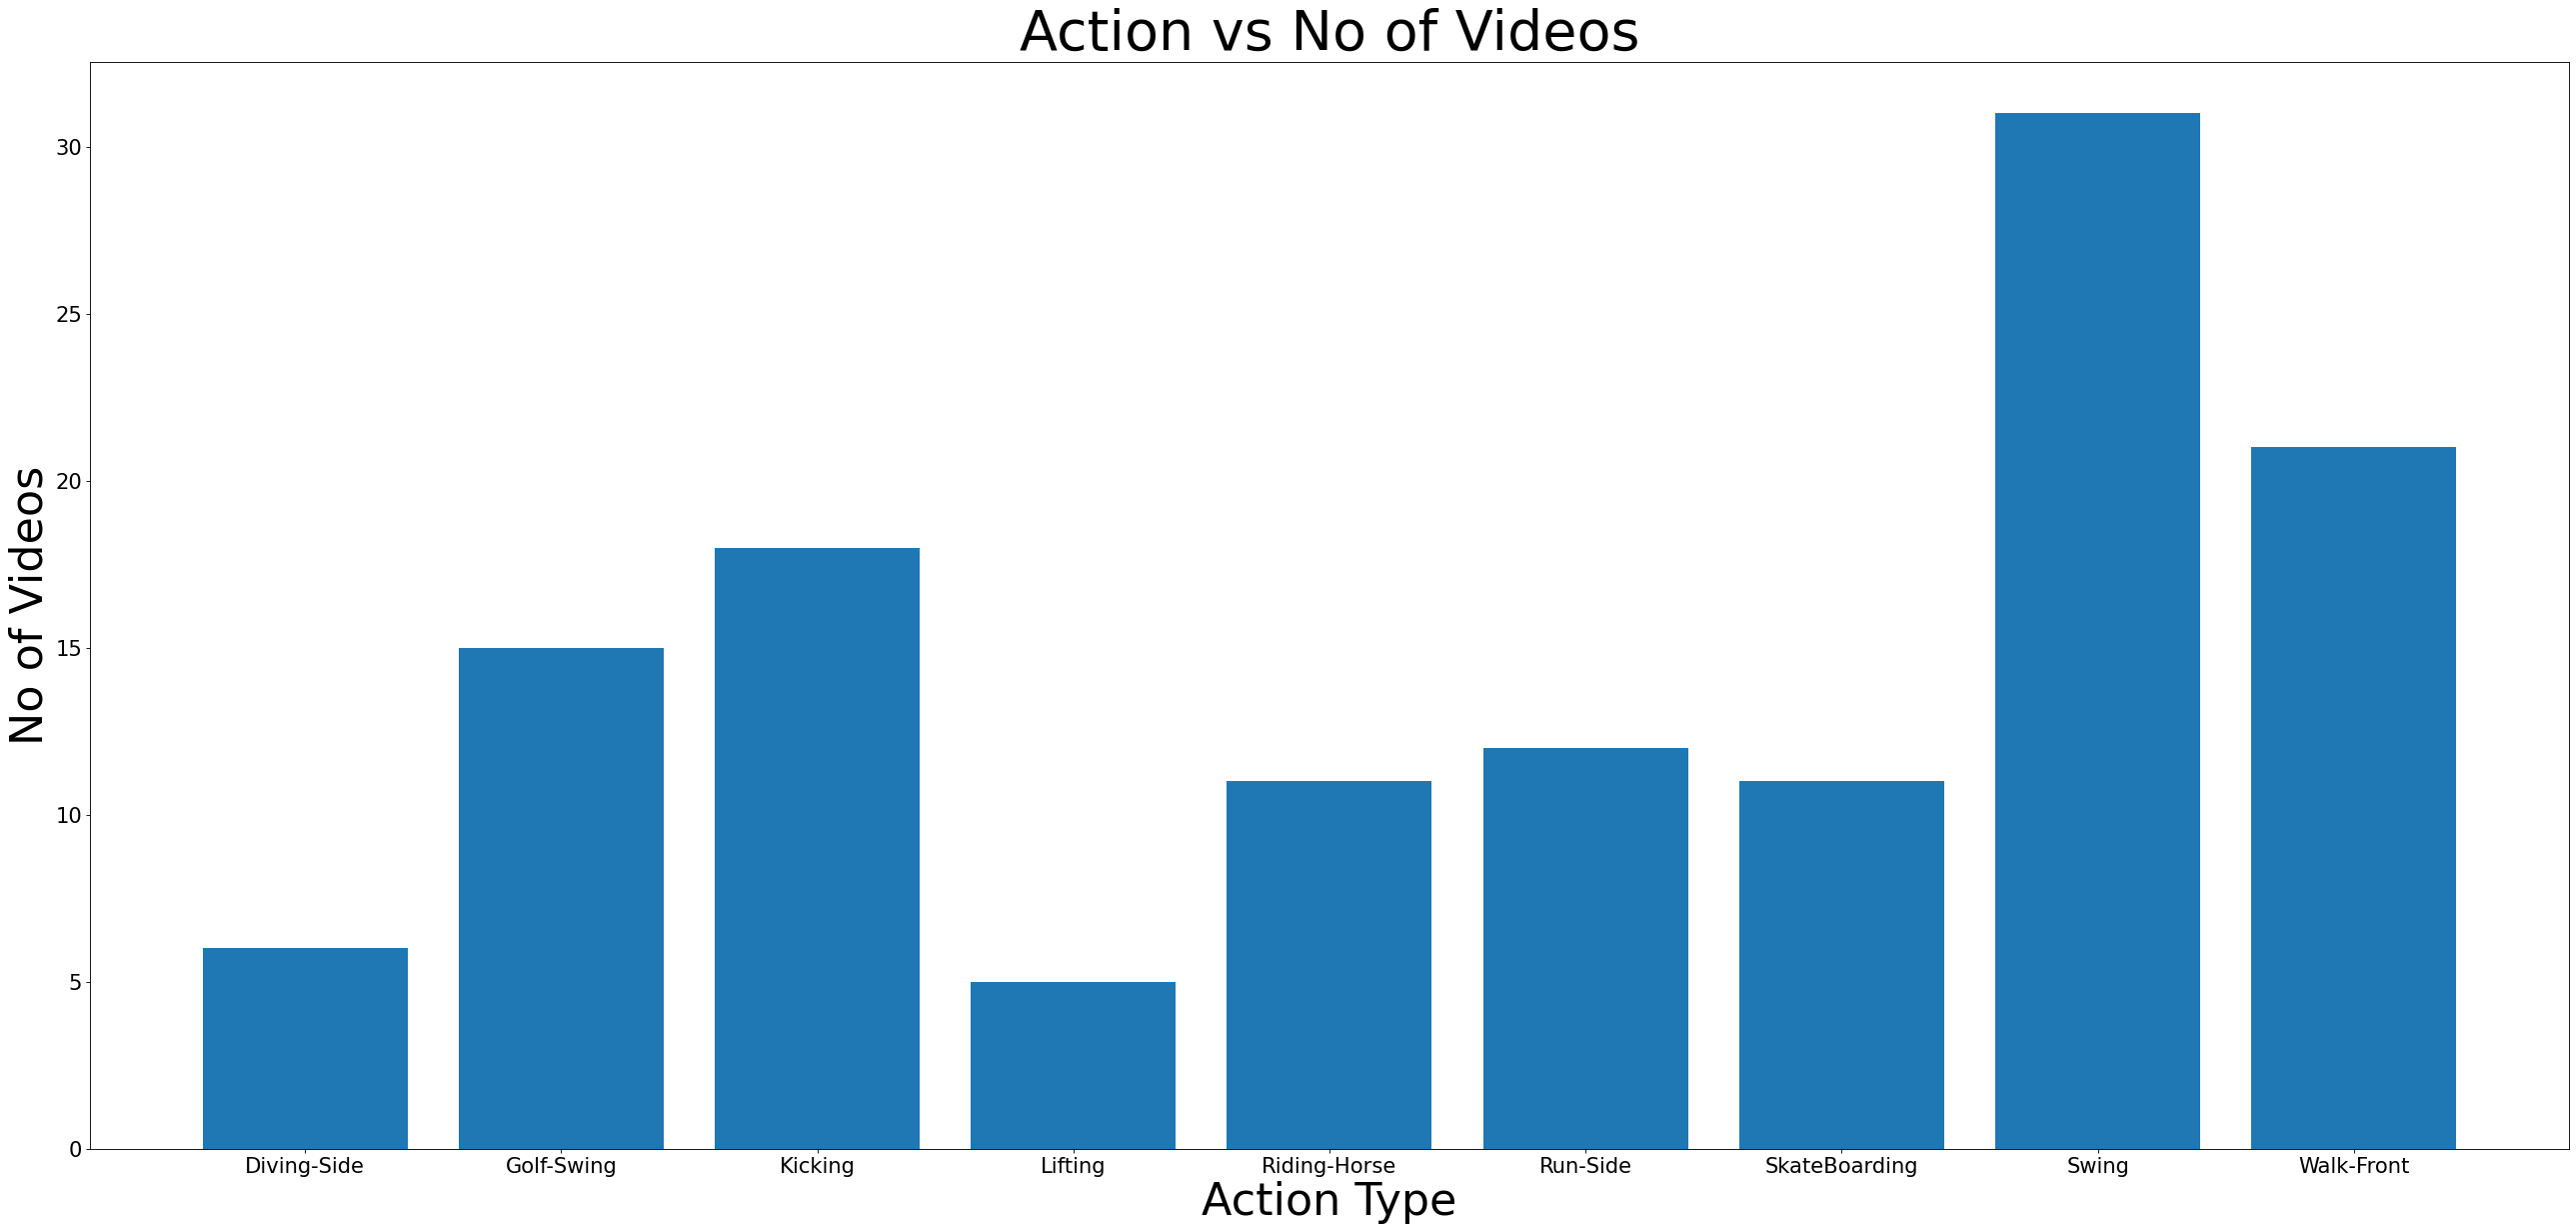

In [28]:
plt.figure(figsize=(40, 18), dpi=80)

font1 = {'size':50}
font2 = {'size':40}
plt.bar(action,no_of_clip)
plt.xlabel('Action Type', fontdict = font2)
plt.ylabel('No of Videos', fontdict = font2)
plt.title('Action vs No of Videos', fontdict = font1)
plt.show()

**(a) Analysis**

We can see from the above results that our dataset is quite unbalanced. The skewness generated by certain actions such as 'swing' and 'walk front' might compromise our model results at a later stage. However, we will let these stay as they are and proceed further.

## 6. Helper Functions for Pre-Processing

Each video is basically a collection of frames which are joined together in succession generating a smooth linked picture. Hence, we will need to convert these videos to first indivdual frames, extract the features from the frames before feeding them on to the sequence model or Recurrent Nueral Network. We will be using the following steps repeatedly so it is paramount that we have individual functions for them to reduce the redundancy.

1. Convert Each Video to Frames
2. Extracting Features from each Frame
3. Label Encoding


**(a) Function to load a video and extract the frames**

In [29]:
# Setting the Image size of each frame which is to be processed later
image_size = 224


def video_framing(path):
    
    vid = cv2.VideoCapture(path)
    frames = []
    
    while True:
        
        # Capturing video frame by frame
        ret , frame = vid.read()
        
        # If the video has ended, break the function
        if not ret:
            break
        frame = cv2.resize(frame , (image_size , image_size))
        frame = frame[:, :, [2, 1, 0]]
        frames.append(frame)
        
        if len(frames) == 0:
            break
            
    vid.release()
    
    return np.array(frames)

**(b) Function to extract Features(CNN)**

In [30]:
# ## Using he inceptionv3 model from keras as transfer learning technique to train the CNN portion
feature_extractor = applications.VGG16(include_top = False ,weights="imagenet", input_shape =(224,224,3),
                                                    pooling = 'avg'  ) 

In [31]:
def extractor():
    ## Using he xgg16 model from keras as transfer learning technique to train the CNN portion

    prep = applications.vgg16.preprocess_input
    
    inputs = keras.Input((image_size , image_size , 3))
    processed = prep(inputs)
    
    outputs = feature_extractor(processed)
    return (keras.Model(inputs , outputs, name = 'feature_extractor'))

extractor = extractor()

**(c) Label Encoding**

Now, we would be designing a preprocessing layer which will be converting the labels into integers. This is important as it is vital for the model training with regard to the loss function that is 'sparse categorical entropy' which essentially requires all labels to be integers. To get this done, we will be using the StringLookUp in keras which would aslo enable us to re-extract the actual labels using the vocabulary() function. 

In [32]:
## the following line creates a vocabulary of variables and the num_oov_indices set to 0
## to remove the OOV token which would generate an unknown as well at the start
enc_layer = keras.layers.StringLookup(vocabulary = df_train.Label.unique(), num_oov_indices=0)

## Using the above encoder to generate the integers for training
video_labels = enc_layer(df_train.Label.values[... , None] ).numpy()

## Label encoding for test set
video_labels_test = enc_layer(df_test.Label.values[... , None] ).numpy()

## 7. Convolutional Nueral Network

Now, using the helper function we desinged aboe, we will convert each video into frames i.e. a collection of pictures which we would then feed to our Convolutional model for features extraction.

In [33]:
batch = 64
num_features = 2048
max_seq = 20

We will be defining a function instead of following the layers without them since we will have to reuse the same method on multiple architectures and data sets. The steps involved in the following function are listed as follows:

1. Initializing the feature matrix to zeros
2. Creating Masks to identify the location of the actual pixels and paddings in the features matrix. Consists of only boolean values.
3. Iterating over each video while converting it to frames, initializing the empty features matrix and masks for each video
4. Iterating over each frame to extract the features from it
5. Writing the results in terms of features and masks for all videos to have a cumulative result in 'frame_feature' and 'frame_mask'.

In [34]:
def video_prep(df, root_dir):
    
    # Creating a variable of sample number to create paddings
    num_samples = len(df)
    
    # Converting the names of the paths of the videos and converting to lis for iteration
    video_rte = df.video_name.values.tolist()
    
    # we'll initialize the features of the frames to zeros to add the frames during loop
    frame_features = np.zeros(shape = (num_samples , max_seq , num_features), dtype= "float32")
    
    # making an array to contain booleans to detect paddings
    frame_mask = np.zeros(shape=(num_samples , max_seq), dtype = "bool")
    
    ## traversing over all video
    for idx, rte in enumerate(video_rte):
        ## loading the video
        frames = video_framing(os.path.join(root_dir, rte))
        frames = frames[None, ...]
        
        ## stoeing the features and masks of the video
        temp_features = np.zeros(shape = (1 , max_seq , num_features), dtype= "float32")
        temp_mask = np.zeros(shape=(1,max_seq) , dtype = 'bool')
        
        for i,b in enumerate(frames):
            length = min(max_seq , b.shape[0])
            
            for j in range(length):
                temp_features[i,j,:] = extractor.predict(b[None, j , :])
                
            temp_mask[i, :length] = 1
            
        ## Adjusting the dimensions    
        frame_features[idx,] = temp_features.squeeze()
        frame_mask[idx, ] = temp_mask.squeeze()
        
    return (frame_features , frame_mask)

In [35]:
df_train_proc = video_prep(df_train, "train")
df_test_proc = video_prep(df_test , "Test")

## 8. Recurrent Nueral Network

Now, after we have got the processed video i.e. converting the video to a collection of frames with padding to mantain all videos of the same arbitrary length, we can use it in our RNN model to predict more accurately.

The following are the various steps in the two models using the 'Gated Recurrent Unit' and the 'Long Short term Memory':

1. Initial GRU Layer with 16 units and 'tanh' activation'
2. Second GRU Layer with 8 units
3. Third Drop Out Layer with rate at 0.4
4. Fourth Dense Layer with activation switched to 'relu'
5. Output Dense Layer with softmax activation since we will be using the probablities for multi-class classification.

We will retain the optiizer to 'adam' throughout since it is under most circumstances the best option with RMSprop performing better in very circumstances. The loss function will be spare crossentropy since it is a case of multi-class classification and metric selected to accuracy.

In [65]:
# Gated Recurrent Unit
def GRU_model():
    class_vocab = enc_layer.get_vocabulary()
    
    ## Instantiating tensors with the feature input set at (20 , 2048) and
    ## masking with input set to (20,)
    frame_features_input = keras.Input(shape = (max_seq, num_features))
    mask_input = keras.Input(shape = (max_seq,), dtype="bool")

    ## The second argument is the [samples , timesteps]
    x = GRU(16,  activation="tanh" ,return_sequences=True)(frame_features_input, mask=mask_input)
    x = GRU(8 , activation="tanh")(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    
    output = Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    ## loss is set to sparse categorical crossentropy to deal with multiclassification problem
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [66]:
# Long Short Term Memory
def LSTM_model():
    class_vocab = enc_layer.get_vocabulary()
    
    ## Instantiating tensors with the feature input set at (20 , 2048) and
    ## masking with input set to (20,)
    frame_features_input = keras.Input(shape = (max_seq, num_features))
    mask_input = keras.Input(shape = (max_seq,), dtype="bool")

    ## The second argument is the [samples , timesteps]
    x = LSTM(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = LSTM(8)(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    
    output = Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

## 9. Model Training

In [67]:
EPOCHS = 10


**(a) RNN GRU**

In [68]:
gru_mod = GRU_model()
csv_logger = CSVLogger("GRU_history_log.csv", append=True)
gru_mod.fit(
        [df_train_proc[0], df_train_proc[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[csv_logger]
    )

Epoch 1/10
4/4 [==============================] - 14s 2s/step - loss: 2.1969 - accuracy: 0.1827 - val_loss: 2.1994 - val_accuracy: 0.1923
Epoch 2/10
4/4 [==============================] - 1s 195ms/step - loss: 2.1952 - accuracy: 0.2500 - val_loss: 2.2013 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 1s 218ms/step - loss: 2.1937 - accuracy: 0.2500 - val_loss: 2.2035 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 1s 250ms/step - loss: 2.1922 - accuracy: 0.2500 - val_loss: 2.2056 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 1s 222ms/step - loss: 2.1907 - accuracy: 0.2500 - val_loss: 2.2079 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 1s 240ms/step - loss: 2.1892 - accuracy: 0.2500 - val_loss: 2.2101 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 1s 214ms/step - loss: 2.1879 - accuracy: 0.2500 - val_loss: 2.2123 - val_accuracy: 0.1923
Epoch 8/10
4/4 [======

**(b) RNN LSTM**

In [69]:
LSTM_mod = LSTM_model()
csv_logger2 = CSVLogger("LSTM_history_log.csv", append=True)
LSTM_mod.fit(
        [df_train_proc[0], df_train_proc[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[csv_logger2]
    )

Epoch 1/10
4/4 [==============================] - 14s 1s/step - loss: 2.1968 - accuracy: 0.1538 - val_loss: 2.1998 - val_accuracy: 0.1923
Epoch 2/10
4/4 [==============================] - 2s 421ms/step - loss: 2.1951 - accuracy: 0.2500 - val_loss: 2.2023 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 3s 901ms/step - loss: 2.1936 - accuracy: 0.2500 - val_loss: 2.2044 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 4s 955ms/step - loss: 2.1920 - accuracy: 0.2500 - val_loss: 2.2066 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 4s 1s/step - loss: 2.1906 - accuracy: 0.2500 - val_loss: 2.2087 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 2s 475ms/step - loss: 2.1892 - accuracy: 0.2500 - val_loss: 2.2109 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 1s 329ms/step - loss: 2.1877 - accuracy: 0.2500 - val_loss: 2.2132 - val_accuracy: 0.1923
Epoch 8/10
4/4 [=========

In [70]:
gru_mod.evaluate([df_test_proc[0], df_test_proc[1]], video_labels_test)

1/1 [==============================] - 0s 201ms/step - loss: 2.1899 - accuracy: 0.1538


[2.18990159034729, 0.1538461595773697]

In [71]:
LSTM_mod.evaluate([df_test_proc[0], df_test_proc[1]], video_labels_test)

1/1 [==============================] - 0s 312ms/step - loss: 2.1896 - accuracy: 0.1538


[2.1895792484283447, 0.1538461595773697]

## 10. Model Test Results

In [72]:
def single_sample_process(path , model):
    
    ## extracting the frames
    frames = video_framing(path)
    
    ## Extracting the features and masks
    temp_df = df_test.loc[df_test.video_name == path]
    frame_features , frame_mask = video_prep(temp_df , 'test')
    
    prob = model.predict([frame_features , frame_mask])[0]
    
    class_vocab = enc_layer.get_vocabulary()
    
    for i in np.argsort(prob)[::-1]:
        print(f"  {class_vocab[i]}: {prob[i] * 100:5.5f}%")


**(a) GRU Layers**

In [73]:
test_video = np.random.choice(df_test["video_name"].values.tolist())
print (test_video)
single_sample_process(test_video , gru_mod)

Data\Test\Kicking\3833-15_70577.avi
  Swing: 11.53731%
  Kicking: 11.40681%
  Golf-Swing: 11.30200%
  SkateBoarding: 11.18815%
  Run-Side: 11.18125%
  Riding-Horse: 11.09461%
  Diving-Side: 10.79766%
  Lifting: 10.77462%
  Walk-Front: 10.71761%


**(b) LSTM Layers**

In [74]:
print (test_video)
single_sample_process(test_video , LSTM_mod)

Data\Test\Kicking\3833-15_70577.avi
  Swing: 11.56780%
  Kicking: 11.41995%
  Golf-Swing: 11.30408%
  Run-Side: 11.16199%
  Riding-Horse: 11.10245%
  SkateBoarding: 11.08756%
  Diving-Side: 10.87276%
  Lifting: 10.77952%
  Walk-Front: 10.70389%


## 11. CNN Extractor Tweaking

As part of our transfer learning technique, we used the vgg16 from the keras applications package which seemingly gives us acceptable results. Now, let us use additional 2 trained models from keras namely 'resnet50' and 'inception_v3'. Since the two RNN designs namely LSTM and GRU aren't producing much different results, we'll be using GRU.

**(a) RESnet50**

In [75]:
feature_extractor = applications.ResNet50(include_top = False ,weights="imagenet", input_shape =(224,224,3),
                                                    pooling = 'avg'  ) 
def extractor():
    ## Using he xgg16 model from keras as transfer learning technique to train the CNN portion

    prep = applications.vgg16.preprocess_input
    
    inputs = keras.Input((image_size , image_size , 3))
    processed = prep(inputs)
    
    outputs = feature_extractor(processed)
    return (keras.Model(inputs , outputs, name = 'feature_extractor'))

extractor = extractor()

In [76]:
df_train_proc_1 = video_prep(df_train, "train")
df_test_proc_1 = video_prep(df_test , "Test")

In [77]:
gru_mod = GRU_model()
csv_logger = CSVLogger("resnet_history_log.csv", append=True)
gru_mod.fit(
        [df_train_proc_1[0], df_train_proc_1[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[csv_logger]
    )

Epoch 1/10
4/4 [==============================] - 9s 870ms/step - loss: 2.1969 - accuracy: 0.1827 - val_loss: 2.1992 - val_accuracy: 0.1923
Epoch 2/10
4/4 [==============================] - 1s 172ms/step - loss: 2.1952 - accuracy: 0.2500 - val_loss: 2.2013 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 1s 235ms/step - loss: 2.1937 - accuracy: 0.2500 - val_loss: 2.2034 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 1s 149ms/step - loss: 2.1922 - accuracy: 0.2500 - val_loss: 2.2056 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 1s 194ms/step - loss: 2.1906 - accuracy: 0.2500 - val_loss: 2.2079 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 1s 177ms/step - loss: 2.1891 - accuracy: 0.2500 - val_loss: 2.2101 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 1s 162ms/step - loss: 2.1875 - accuracy: 0.2500 - val_loss: 2.2122 - val_accuracy: 0.1923
Epoch 8/10
4/4 [====

In [78]:
print (test_video)
single_sample_process(test_video , gru_mod)

Data\Test\Kicking\3833-15_70577.avi
  Swing: 11.57794%
  Kicking: 11.42727%
  Golf-Swing: 11.31902%
  Run-Side: 11.19438%
  Riding-Horse: 11.11481%
  SkateBoarding: 11.09069%
  Diving-Side: 10.79267%
  Lifting: 10.76605%
  Walk-Front: 10.71716%


**(b) Inception_v3**

In [79]:
feature_extractor = applications.InceptionV3(include_top = False ,weights="imagenet", input_shape =(224,224,3),
                                                    pooling = 'avg'  ) 
def extractor():
    ## Using he xgg16 model from keras as transfer learning technique to train the CNN portion

    prep = applications.vgg16.preprocess_input
    
    inputs = keras.Input((image_size , image_size , 3))
    processed = prep(inputs)
    
    outputs = feature_extractor(processed)
    return (keras.Model(inputs , outputs, name = 'feature_extractor'))

extractor = extractor()

In [80]:
df_train_proc_2 = video_prep(df_train, "train")
df_test_proc_2 = video_prep(df_test , "Test")

In [81]:
gru_mod = GRU_model()
csv_logger = CSVLogger("inceptionv3_history_log.csv", append=True)
gru_mod.fit(
        [df_train_proc_2[0], df_train_proc_2[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[csv_logger]
    )

Epoch 1/10
4/4 [==============================] - 13s 893ms/step - loss: 2.1967 - accuracy: 0.1058 - val_loss: 2.1993 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 1s 170ms/step - loss: 2.1952 - accuracy: 0.1827 - val_loss: 2.2016 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 1s 173ms/step - loss: 2.1936 - accuracy: 0.1731 - val_loss: 2.2039 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 1s 285ms/step - loss: 2.1922 - accuracy: 0.1731 - val_loss: 2.2062 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 1s 210ms/step - loss: 2.1907 - accuracy: 0.2500 - val_loss: 2.2085 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 1s 124ms/step - loss: 2.1894 - accuracy: 0.2500 - val_loss: 2.2109 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 0s 128ms/step - loss: 2.1879 - accuracy: 0.2500 - val_loss: 2.2132 - val_accuracy: 0.1923
Epoch 8

In [82]:
print (test_video)
single_sample_process(test_video , gru_mod)

Data\Test\Kicking\3833-15_70577.avi
  Swing: 11.49227%
  Kicking: 11.46915%
  Golf-Swing: 11.33133%
  Run-Side: 11.21216%
  SkateBoarding: 11.11855%
  Riding-Horse: 11.07936%
  Diving-Side: 10.81318%
  Lifting: 10.77098%
  Walk-Front: 10.71301%


## 12. Results and Analysis

**(a) RNN Model Architecture Comparison**

In [83]:
gru_res = pd.read_csv(r'GRU_history_log.csv')
gru_res

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.182692,2.196924,0.192308,2.199375
1,1,0.250000,2.195204,0.192308,2.201330
2,2,0.250000,2.193718,0.192308,2.203471
3,3,0.250000,2.192199,0.192308,2.205624
4,4,0.250000,2.190674,0.192308,2.207853
5,5,0.250000,2.189220,0.192308,2.210109
6,6,0.250000,2.187874,0.192308,2.212326
7,7,0.250000,2.186419,0.192308,2.214628
8,8,0.250000,2.184973,0.192308,2.216909
9,9,0.250000,2.183540,0.192308,2.219109


In [84]:
lstm_res = pd.read_csv(r'LSTM_history_log.csv')
lstm_res

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.153846,2.196823,0.192308,2.199847
1,1,0.250000,2.195052,0.192308,2.202263
2,2,0.250000,2.193632,0.192308,2.204413
3,3,0.250000,2.192045,0.192308,2.206594
4,4,0.250000,2.190572,0.192308,2.208745
5,5,0.250000,2.189223,0.192308,2.210915
6,6,0.250000,2.187682,0.192308,2.213237
7,7,0.250000,2.186308,0.192308,2.215436
8,8,0.250000,2.184868,0.192308,2.217546
9,9,0.250000,2.183417,0.192308,2.219637


<AxesSubplot:title={'center':'GRU Accuracy'}, xlabel='epoch'>

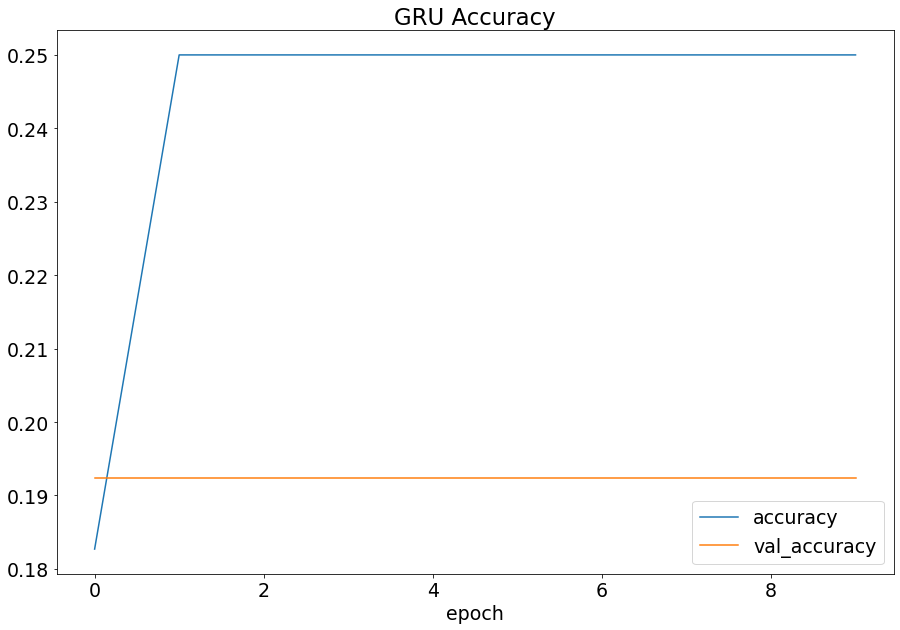

In [85]:
gru_res.plot.line(x = 'epoch' , y = ['accuracy','val_accuracy'], figsize=(15, 10), title='GRU Accuracy')

<AxesSubplot:title={'center':'LSTM Accuracy'}, xlabel='epoch'>

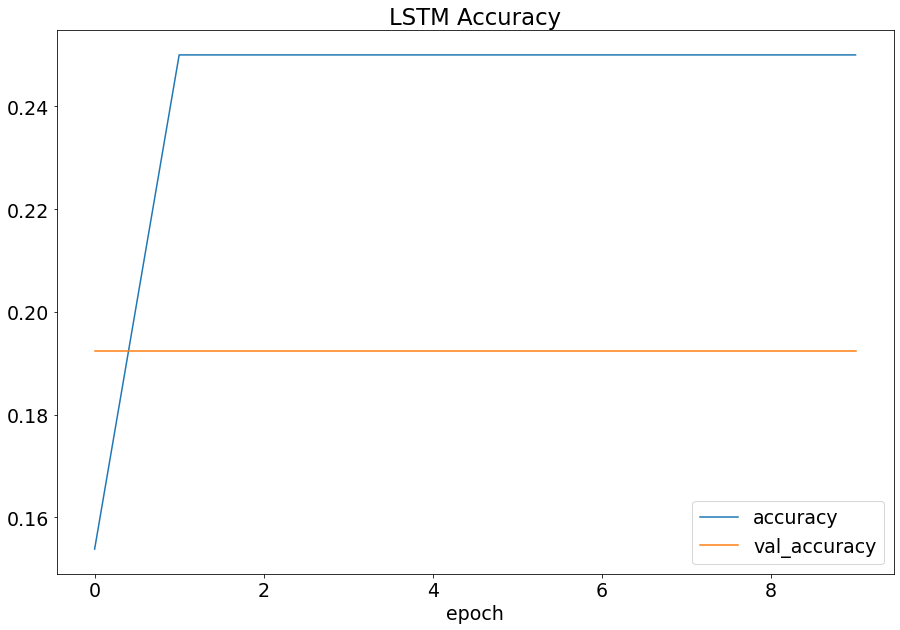

In [86]:
lstm_res.plot.line(x = 'epoch' , y = ['accuracy','val_accuracy'], figsize=(15, 10), title='LSTM Accuracy')

**(b) CNN Model Architecture Comparison**

In [87]:
resnet_res = pd.read_csv(r'resnet_history_log.csv')
inceptionv3_res = pd.read_csv(r'inceptionv3_history_log.csv')

<AxesSubplot:title={'center':'RESNET Accuracy'}, xlabel='epoch'>

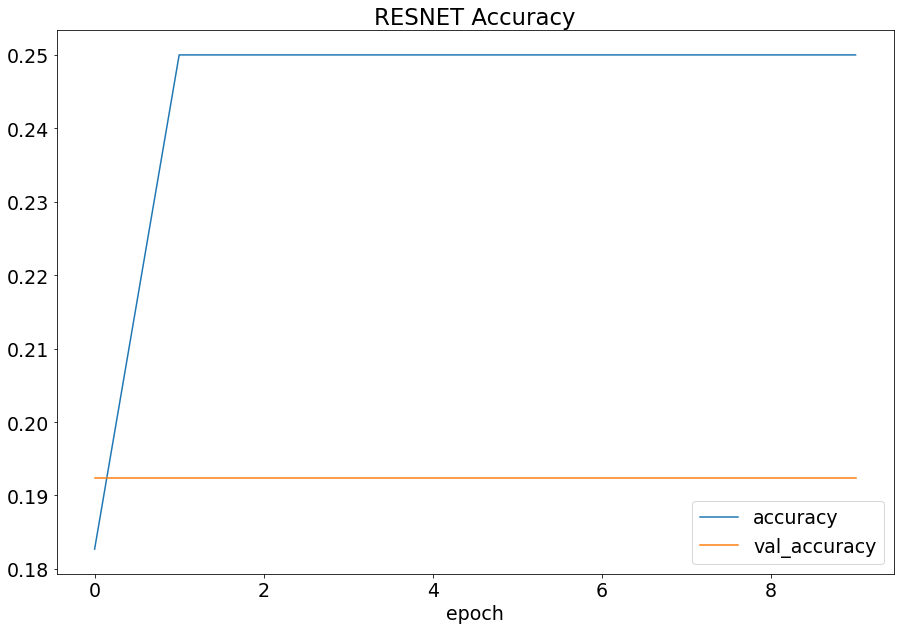

In [88]:
resnet_res.plot.line(x = 'epoch' , y = ['accuracy','val_accuracy'], figsize=(15, 10), title='RESNET Accuracy')

<AxesSubplot:title={'center':'Inception_v3'}, xlabel='epoch'>

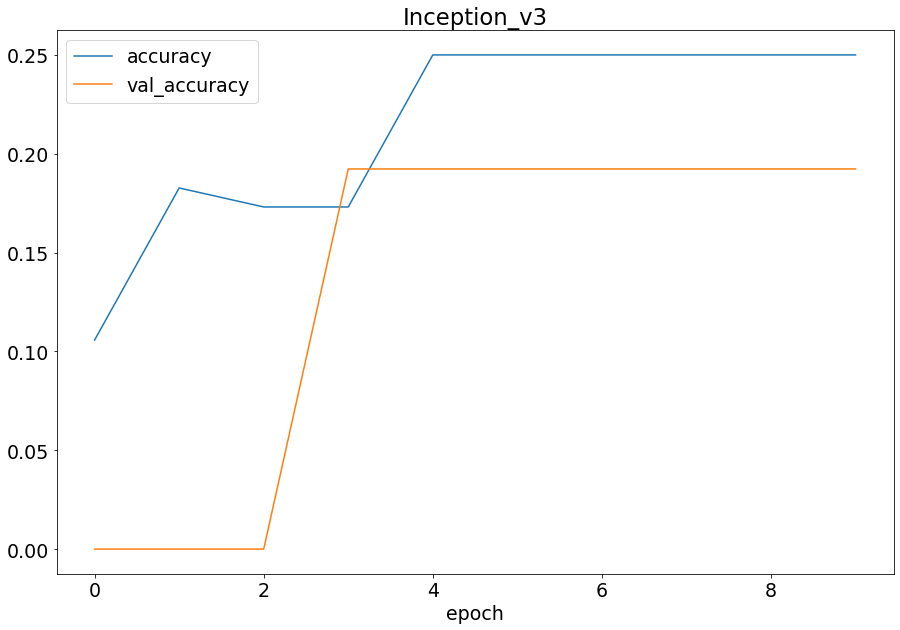

In [89]:
inceptionv3_res.plot.line(x = 'epoch' , y = ['accuracy','val_accuracy'], figsize=(15, 10), title='Inception_v3')

**(c) Optmizer Finalization**

**RMSprop**

In [92]:
# Gated Recurrent Unit
def GRU_model():
    class_vocab = enc_layer.get_vocabulary()
    
    ## Instantiating tensors with the feature input set at (20 , 2048) and
    ## masking with input set to (20,)
    frame_features_input = keras.Input(shape = (max_seq, num_features))
    mask_input = keras.Input(shape = (max_seq,), dtype="bool")

    ## The second argument is the [samples , timesteps]
    x = GRU(16,  activation="tanh" ,return_sequences=True)(frame_features_input, mask=mask_input)
    x = GRU(8 , activation="tanh")(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    
    output = Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    ## loss is set to sparse categorical crossentropy to deal with multiclassification problem
    ##########
    opt = keras.optimizers.RMSprop(learning_rate= 0.01)
    #########
    
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
    )
    return rnn_model

gru_mod = GRU_model()
csv_logger = CSVLogger("rmsprop_history_log.csv", append=True)
gru_mod.fit(
        [df_train_proc[0], df_train_proc[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[csv_logger]
    )

Epoch 1/10
4/4 [==============================] - 15s 2s/step - loss: 2.1854 - accuracy: 0.1250 - val_loss: 2.2598 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 1s 212ms/step - loss: 2.1606 - accuracy: 0.1442 - val_loss: 2.2926 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 1s 266ms/step - loss: 2.1427 - accuracy: 0.1635 - val_loss: 2.3205 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 1s 387ms/step - loss: 2.1307 - accuracy: 0.2500 - val_loss: 2.3465 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 1s 340ms/step - loss: 2.1198 - accuracy: 0.2500 - val_loss: 2.3720 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 1s 388ms/step - loss: 2.1091 - accuracy: 0.2500 - val_loss: 2.3967 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 1s 278ms/step - loss: 2.1000 - accuracy: 0.2500 - val_loss: 2.4221 - val_accuracy: 0.1923
Epoch 8/10
4/4

**AdaDelta**

In [94]:
# Gated Recurrent Unit
def GRU_model():
    class_vocab = enc_layer.get_vocabulary()
    
    ## Instantiating tensors with the feature input set at (20 , 2048) and
    ## masking with input set to (20,)
    frame_features_input = keras.Input(shape = (max_seq, num_features))
    mask_input = keras.Input(shape = (max_seq,), dtype="bool")

    ## The second argument is the [samples , timesteps]
    x = GRU(16,  activation="tanh" ,return_sequences=True)(frame_features_input, mask=mask_input)
    x = GRU(8 , activation="tanh")(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    
    output = Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    ## loss is set to sparse categorical crossentropy to deal with multiclassification problem
    ##########
    opt = keras.optimizers.Adadelta(learning_rate= 0.01)
    #########
    
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
    )
    return rnn_model

gru_mod = GRU_model()
csv_logger = CSVLogger("adadelta_history_log.csv", append=True)
gru_mod.fit(
        [df_train_proc[0], df_train_proc[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[csv_logger]
    )

Epoch 1/10
4/4 [==============================] - 11s 999ms/step - loss: 2.1972 - accuracy: 0.1442 - val_loss: 2.1973 - val_accuracy: 0.1923
Epoch 2/10
4/4 [==============================] - 1s 271ms/step - loss: 2.1972 - accuracy: 0.2500 - val_loss: 2.1973 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 2s 489ms/step - loss: 2.1972 - accuracy: 0.2500 - val_loss: 2.1973 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 1s 235ms/step - loss: 2.1972 - accuracy: 0.2500 - val_loss: 2.1973 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 1s 191ms/step - loss: 2.1971 - accuracy: 0.2500 - val_loss: 2.1974 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 1s 233ms/step - loss: 2.1971 - accuracy: 0.2500 - val_loss: 2.1974 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 1s 196ms/step - loss: 2.1971 - accuracy: 0.2500 - val_loss: 2.1974 - val_accuracy: 0.1923
Epoch 8/10
4/4 [===

**(c) Hyperparameters Tweaking on Final Model**

Using 3 learning Rates ie.e 0.01, 0.05 and 0.08

In [98]:
# Gated Recurrent Unit
def GRU_model():
    class_vocab = enc_layer.get_vocabulary()
    
    ## Instantiating tensors with the feature input set at (20 , 2048) and
    ## masking with input set to (20,)
    frame_features_input = keras.Input(shape = (max_seq, num_features))
    mask_input = keras.Input(shape = (max_seq,), dtype="bool")

    ## The second argument is the [samples , timesteps]
    x = GRU(16,  activation="tanh" ,return_sequences=True)(frame_features_input, mask=mask_input)
    x = GRU(8 , activation="tanh")(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    
    output = Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    ## loss is set to sparse categorical crossentropy to deal with multiclassification problem
    ##########
    opt = keras.optimizers.Adam(lr= 0.01)
    #########
    
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
    )
    return rnn_model

gru_mod.fit(
        [df_train_proc[0], df_train_proc[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS
    )

Epoch 1/10
4/4 [==============================] - 1s 207ms/step - loss: 2.1965 - accuracy: 0.2500 - val_loss: 2.1982 - val_accuracy: 0.1923
Epoch 2/10
4/4 [==============================] - 1s 159ms/step - loss: 2.1965 - accuracy: 0.2500 - val_loss: 2.1983 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 1s 205ms/step - loss: 2.1965 - accuracy: 0.2500 - val_loss: 2.1983 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 1s 207ms/step - loss: 2.1965 - accuracy: 0.2500 - val_loss: 2.1983 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 1s 215ms/step - loss: 2.1965 - accuracy: 0.2500 - val_loss: 2.1984 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 1s 184ms/step - loss: 2.1964 - accuracy: 0.2500 - val_loss: 2.1984 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 1s 210ms/step - loss: 2.1964 - accuracy: 0.2500 - val_loss: 2.1984 - val_accuracy: 0.1923
Epoch 8/10
4/4 [====

In [96]:
# Gated Recurrent Unit
def GRU_model():
    class_vocab = enc_layer.get_vocabulary()
    
    ## Instantiating tensors with the feature input set at (20 , 2048) and
    ## masking with input set to (20,)
    frame_features_input = keras.Input(shape = (max_seq, num_features))
    mask_input = keras.Input(shape = (max_seq,), dtype="bool")

    ## The second argument is the [samples , timesteps]
    x = GRU(16,  activation="tanh" ,return_sequences=True)(frame_features_input, mask=mask_input)
    x = GRU(8 , activation="tanh")(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    
    output = Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    ## loss is set to sparse categorical crossentropy to deal with multiclassification problem
    ##########
    opt = keras.optimizers.Adam(lr= 0.05)
    #########
    
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

gru_mod.fit(
        [df_train_proc[0], df_train_proc[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS
    )

Epoch 1/10
4/4 [==============================] - 1s 206ms/step - loss: 2.1970 - accuracy: 0.2500 - val_loss: 2.1976 - val_accuracy: 0.1923
Epoch 2/10
4/4 [==============================] - 1s 232ms/step - loss: 2.1970 - accuracy: 0.2500 - val_loss: 2.1976 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 1s 243ms/step - loss: 2.1970 - accuracy: 0.2500 - val_loss: 2.1976 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 1s 180ms/step - loss: 2.1969 - accuracy: 0.2500 - val_loss: 2.1977 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 1s 132ms/step - loss: 2.1969 - accuracy: 0.2500 - val_loss: 2.1977 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 1s 205ms/step - loss: 2.1969 - accuracy: 0.2500 - val_loss: 2.1977 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 1s 127ms/step - loss: 2.1969 - accuracy: 0.2500 - val_loss: 2.1978 - val_accuracy: 0.1923
Epoch 8/10
4/4 [====

In [97]:
# Gated Recurrent Unit
def GRU_model():
    class_vocab = enc_layer.get_vocabulary()
    
    ## Instantiating tensors with the feature input set at (20 , 2048) and
    ## masking with input set to (20,)
    frame_features_input = keras.Input(shape = (max_seq, num_features))
    mask_input = keras.Input(shape = (max_seq,), dtype="bool")

    ## The second argument is the [samples , timesteps]
    x = GRU(16,  activation="tanh" ,return_sequences=True)(frame_features_input, mask=mask_input)
    x = GRU(8 , activation="tanh")(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    
    output = Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    ## loss is set to sparse categorical crossentropy to deal with multiclassification problem
    ##########
    opt = keras.optimizers.Adam(lr= 0.08)
    #########
    
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

gru_mod.fit(
        [df_train_proc[0], df_train_proc[1]],
        video_labels,
        validation_split=0.2,
        epochs=EPOCHS
    )

Epoch 1/10
4/4 [==============================] - 1s 241ms/step - loss: 2.1968 - accuracy: 0.2500 - val_loss: 2.1979 - val_accuracy: 0.1923
Epoch 2/10
4/4 [==============================] - 1s 287ms/step - loss: 2.1968 - accuracy: 0.2500 - val_loss: 2.1979 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 1s 306ms/step - loss: 2.1967 - accuracy: 0.2500 - val_loss: 2.1979 - val_accuracy: 0.1923
Epoch 4/10
4/4 [==============================] - 1s 307ms/step - loss: 2.1967 - accuracy: 0.2500 - val_loss: 2.1980 - val_accuracy: 0.1923
Epoch 5/10
4/4 [==============================] - 1s 354ms/step - loss: 2.1967 - accuracy: 0.2500 - val_loss: 2.1980 - val_accuracy: 0.1923
Epoch 6/10
4/4 [==============================] - 1s 240ms/step - loss: 2.1967 - accuracy: 0.2500 - val_loss: 2.1981 - val_accuracy: 0.1923
Epoch 7/10
4/4 [==============================] - 1s 194ms/step - loss: 2.1966 - accuracy: 0.2500 - val_loss: 2.1981 - val_accuracy: 0.1923
Epoch 8/10
4/4 [====

**(d) Analysis**

After training both the GRU and LSTM model on the data, we found that neither was performing well on the data. The accuracy that we got on the training data was a mere 25% and 19% on the validation data which is quite low. Both these method seem to be performing quite similar which would lead us to choose the GRU as the better option due to its advantage in terms of time complexity.

When we changed the CNN model to 'resnet50' and 'inception_v3', we got the same results as before with the 'vgg16' model in terms of model training. Howeer, when we attempted to predict the same test video using these different CNN structures, there was a slight change in the overall predictive results albeit negligible. 

In lieu, of both these observations, the most probable reason for the inaccuracy of the results stems from the fact that the dataset is simply too small and not balanced which is compromising our model. Moreover, additional tweaking of the layers and hyperparameters inside the CNN models might improve our results further.

The best model we have will have the following main components:

1. CNN 'resnet50' (Though not much difference against the other 2 models as well)
2. RNN with GRU due to better time complexity against LSTM layer
3. Optimizer set to Adam
4. Learning Rate 0.08

## 13. Conclusion

This was a fairly simple approach to classify a video which followed the breaking of video of frames, then extracting the features through CNN and passsing it through the RNN to make a final prediction. The important takeaways from the project are listed as follows:

1. Dividing a video into frames
2. Using Transfer Learning techniques to extract features
3. Importance of Masking for sequence models like RNN
4. Need for balancing of datasets
5. Need for tweaking of parameters and hyperparameters inside imported models

In future, the basic model that we designed may be improved by integrating techniques such as data augmentation to enhance our ability to extract features from each frame. Moreover, the transfer learning models might also be optimized by tuning the hyperparameters further.

## 14. References

1. https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/
2. https://keras.io/api/layers/preprocessing_layers/categorical/category_encoding/
3. https://keras.io/api/applications/vgg/#vgg16-function
4. https://keras.io/api/applications/#extract-features-with-vgg16
5. https://keras.io/examples/vision/video_classification/
6. https://keras.io/api/layers/recurrent_layers/gru/
7. https://www.tensorflow.org/guide/keras/masking_and_padding